[DONE] Necessary imports for seq2seq model

In [ ]:
import os
import sys
import torch
import random
import numpy as np
import pandas as pd
from uu import Error
import torch.nn as nn
from tqdm import trange
from torch import optim
from datetime import datetime
from google.colab import drive
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error

drive.mount('/content/drive', force_remount=True)
project = '/content/drive/My Drive/final_project'
sys.path.append(project)

from RICODataset import *
from seq2seq import *

Mounted at /content/drive


# 1. Defining data

In [ ]:

df_1 = pd.read_hdf(os.path.join(project, 'src/RICO1_Dataset.hdf'), key='all')

full_dataset = RICOFullDataset(data=df_1,
                               ori_seq_len=240,
                               tgt_seq_len=240,
                               stride=1,
                               channels=['B.RTD1'],
                               standardize=True)

dataset_1 = RICODataset(
    full_dataset,
    kind="full",
    get_every=10
)

data = pd.read_csv(os.path.join(project, 'src/rico1_full.tsv'), header=0, usecols=range(1,25))
data = np.array(data)
print(f'Data shape: {data.shape}')
data = torch.from_numpy(data)
data = data.reshape(data.shape[0], data.shape[1], 1)
print(f'Data reshaped to add feature: {data.shape}')


Data shape: (102, 24)
Data reshaped to add feature: torch.Size([102, 24, 1])


# 2. Processing the data

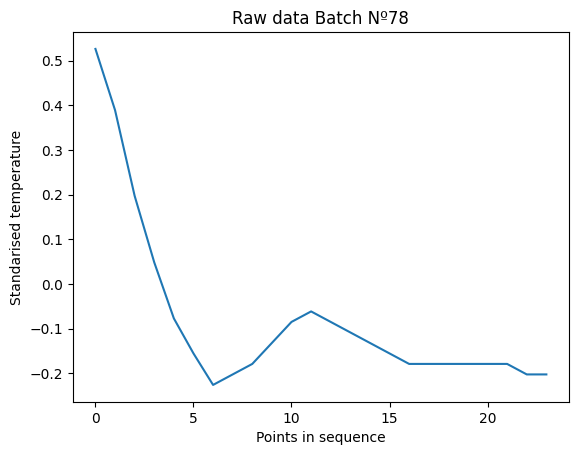

Processing data to size inputs and outputs for different forecast horizons... 
Inputs shape : torch.Size([18, 102, 1])
Targets shape : torch.Size([6, 102, 1])


In [ ]:
# Visualise raw data
idx = np.random.randint(0, data.shape[0])
plt.title(f'Raw data Batch Nº{idx}')
plt.xlabel('Points in sequence')
plt.ylabel('Standarised temperature')
plt.plot(data[idx])
plt.show()

print('Processing data to size inputs and outputs for different forecast horizons... ')

# shape (seq_len, batch_size, input_size)
forecast_horizon = 6

inputs, targets = data[:,:-forecast_horizon,:].permute(1,0,2).float(), data[:,-forecast_horizon:,:].permute(1,0,2).float()

print(f"Inputs shape :", inputs.shape)
print(f"Targets shape :", targets.shape)





# 3. Defining the model

## 3.1 Hyperparameter tuning


In [ ]:
#!pip install optuna
import optuna
import torch
from torch.utils.data import DataLoader, random_split
import numpy as np

def objective(trial):

  # Define hyperparameters
  input_size = 1
  num_layers = trial.suggest_int('num_layers', 1, 4)
  hidden_size = trial.suggest_int('hidden_size', 50, 200, step=50)
  learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
  n_epochs = 50
  batch_size = 16
  target_len = 6

  model = lstm_seq2seq(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)  # Initialize model

  mse = model.train_model(input_tensor=inputs, target_tensor=targets, n_epochs=n_epochs, target_len=target_len, batch_size=batch_size, training_prediction='recursive', teacher_forcing_ratio=0.5, learning_rate=learning_rate, dynamic_tf=False) # Train and evaluate model

  final_loss = np.mean(mse)

  return final_loss

def hyperparameter_tuning(inputs, targets, n_trials=50):
  study = optuna.create_study(direction='minimize')
  study.optimize(objective, n_trials=n_trials)
  best_trial = study.best_trial

  return best_trial.params

# Example usage:
best_params = hyperparameter_tuning(inputs, targets)
print(f"Best hyperparameters: {best_params}")


[I 2023-12-19 11:59:50,828] A new study created in memory with name: no-name-625dda92-7b79-4de1-bac0-de5ffb6f9f6d
100%|██████████| 50/50 [00:17<00:00,  2.86it/s, loss=0.002]
[I 2023-12-19 12:00:08,342] Trial 0 finished with value: 0.06587959608160115 and parameters: {'num_layers': 2, 'hidden_size': 100, 'learning_rate': 0.006342614411137422}. Best is trial 0 with value: 0.06587959608160115.
100%|██████████| 50/50 [00:36<00:00,  1.38it/s, loss=0.001]
[I 2023-12-19 12:00:44,517] Trial 1 finished with value: 0.11932172115368304 and parameters: {'num_layers': 4, 'hidden_size': 150, 'learning_rate': 0.0025169326983279583}. Best is trial 0 with value: 0.06587959608160115.
100%|██████████| 50/50 [00:09<00:00,  5.14it/s, loss=0.002]
[I 2023-12-19 12:00:54,261] Trial 2 finished with value: 0.054684476896703325 and parameters: {'num_layers': 3, 'hidden_size': 50, 'learning_rate': 0.004325904390368096}. Best is trial 2 with value: 0.054684476896703325.
100%|██████████| 50/50 [00:33<00:00,  1.49it

Best hyperparameters: {'num_layers': 1, 'hidden_size': 100, 'learning_rate': 0.008460442070789408}


100%|██████████| 50/50 [00:04<00:00, 11.01it/s, loss=0.002]


Mean Squared Error: 0.03716367483139038


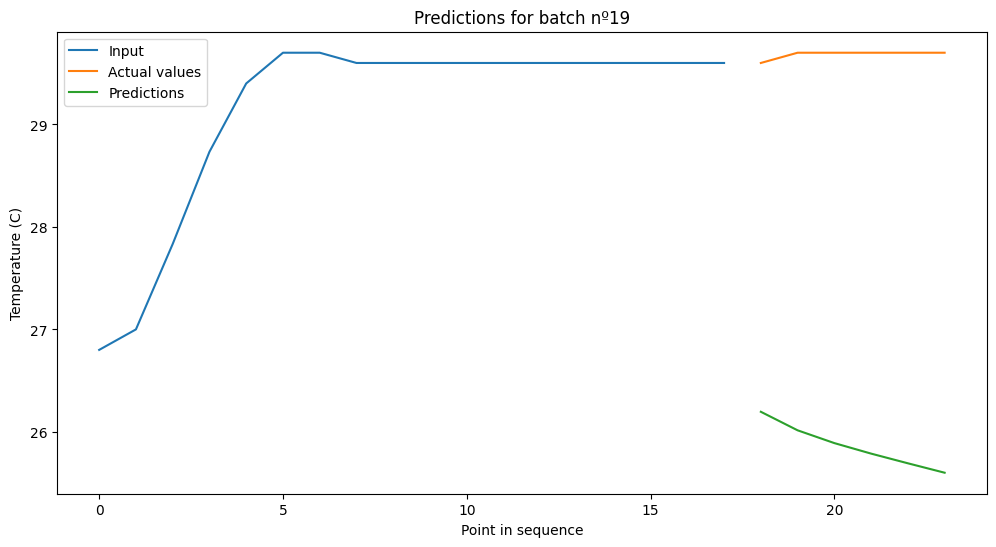

In [ ]:
# Assuming you have the best hyperparameters
best_params_6 = {'num_layers': 1, 'hidden_size': 100, 'learning_rate': 0.008460442070789408}
#best_params_12 = {'num_layers': 1, 'hidden_size': 200, 'learning_rate': 0.004088763457378052}
#best_params_20 = {'num_layers': 2, 'hidden_size': 200, 'learning_rate': 0.002067946260244051}

# Step 1: Build the Model
model = lstm_seq2seq(input_size=1, hidden_size=best_params_6['hidden_size'], num_layers=best_params_6['num_layers'])

# Step 2: Train the Model

n_epochs = 50
model.train_model(inputs, targets, n_epochs, target_len=6, batch_size=16, training_prediction='recursive', teacher_forcing_ratio=0.5, learning_rate=best_params_6['learning_rate'], dynamic_tf=False,show_progress = True)

# Step 3: Make Predictions
predictions = model.predict(targets[:, idx], target_len=forecast_horizon)

# Step 4: Evaluate Performance
mse = mean_squared_error(targets[:,idx], predictions)  # Replace with actual test targets
print(f"Mean Squared Error: {mse}")


# Step 5: Plot Predictions
scaler = full_dataset.get_scaler()
idx = np.random.randint(0, targets.shape[1])

pred_start = len(inputs)
pred_end = pred_start + len(predictions)

pl_inputs = scaler.inverse_transform(inputs[:, idx].reshape(-1,1))
pl_targets = scaler.inverse_transform(targets[:, idx].reshape(-1,1))
pl_predictions = scaler.inverse_transform(predictions.reshape(-1,1))

plt.figure(figsize=(12, 6))
plt.plot(pl_inputs, label='Input')
plt.plot(np.arange(pred_start, pred_end),pl_targets, label='Actual values')
plt.plot(np.arange(pred_start, pred_end),pl_predictions, label='Predictions')
plt.title(f'Predictions for batch nº{idx}')
plt.xlabel('Point in sequence')
plt.ylabel('Temperature (C)')
plt.legend(loc='best')
time = datetime.now().strftime("%d_%H%M")
plt.savefig(os.path.join(project,f'images/seq2seq_lstm/{time}_F6_{mse:.3f}.png'))
plt.show()


